In [22]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from PIL import Image

In [2]:
from utils.openpose_net import OpenPoseNet

#学習済みモデルと本書のモデルでネットワークの層の名前が違うので，対応させてロードする
#モデルの定義
net = OpenPoseNet()

#学習済みのパラメタをロード
net_weights=torch.load('./weights/pose_model_scratch.pth',map_location={'cuda:':'cpu'})
keys=list(net_weights.keys())

weights_load={}

#学習した内容を本書で構築したモデルのパラメタ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]]=net_weights[list(keys)[i]]
    
#コピーした内容をモデルに与える
state=net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


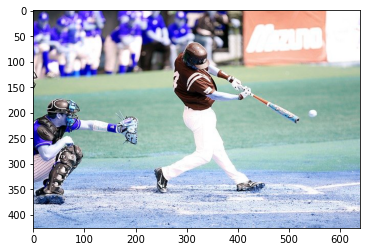

In [12]:
#踊っている人の画像を読み込み前処理する
#pixabay.comよりダウンロード
#画像権利 Pixabay License　商用利用無料　帰属表示は必要ありません

test_image='./data/hit-1407826_640.jpg'
oriImg=cv2.imread(test_image)
plt.imshow(oriImg)
plt.show()

#画像のリサイズ
size=(368,368)
img=cv2.resize(oriImg,size,interpolation=cv2.INTER_CUBIC)

#画像の前処理
img=img.astype(np.float)/255.

#色情報の標準化
color_mean=[0.485,0.456,0.406]
color_std=[0.229,0.224,0.225]

preprocessed_img=img.copy()[:,:,::-1] #BGR2RGB

for i in range(3):
    preprocessed_img[:,:,i]=preprocessed_img[:,:,i]-color_mean[i]
    preprocessed_img[:,:,i]=preprocessed_img[:,:,i] / color_std[i]
    
#(高さ，幅，色)→(色，高さ，幅)
img=preprocessed_img.transpose((2,0,1)).astype(np.float32)

#画像をTensorに
img=torch.from_numpy(img)

#ミニバッチ化
x=img.unsqueeze(0)

In [13]:
#OpenPoseでheatmapsとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)

#画像をテンソルからNumPyに変化し，サイズをもとに戻す
pafs=predicted_outputs[0][0].detach().numpy().transpose(1,2,0)
heatmaps=predicted_outputs[1][0].detach().numpy().transpose(1,2,0)

pafs=cv2.resize(pafs,size,interpolation=cv2.INTER_CUBIC)
heatmaps=cv2.resize(heatmaps,size,interpolation=cv2.INTER_CUBIC)

pafs=cv2.resize(pafs,(oriImg.shape[1],oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps=cv2.resize(heatmaps,(oriImg.shape[1],oriImg.shape[0]),interpolation=cv2.INTER_CUBIC)

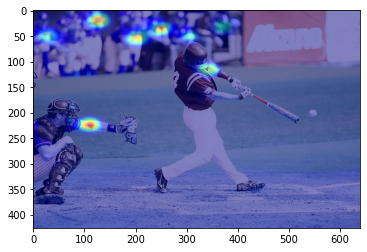

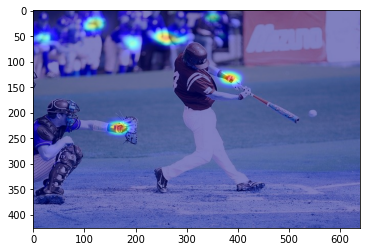

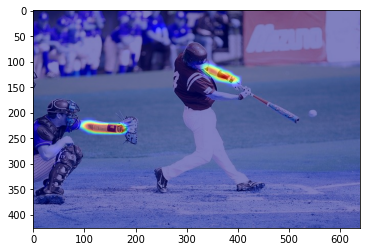

In [24]:
#左肘と左手首のheatmap，そして左肘と左手首を繋ぐPAFのxベクトルを可視化する
#左肘
heat_map=heatmaps[:,:,6]
heat_map=Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map=np.asarray(heat_map.convert('RGB'))

#合成して表示
blend_img=cv2.addWeighted(oriImg,0.5,heat_map,0.5,0)
plt.imshow(blend_img)
plt.show()

#左手首
heat_map=heatmaps[:,:,7]
heat_map=Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map=np.asarray(heat_map.convert('RGB'))

#合成して表示
blend_img=cv2.addWeighted(oriImg,0.5,heat_map,0.5,0)
plt.imshow(blend_img)
plt.show()

#左手首と左肘を繋ぐPAFのxベクトル
paf=pafs[:,:,24]
paf=Image.fromarray(np.uint8(cm.jet(paf)*255))
paf=np.asarray(paf.convert('RGB'))

#合成して表示
blend_img=cv2.addWeighted(oriImg,0.5,paf,0.5,0)
plt.imshow(blend_img)
plt.show()

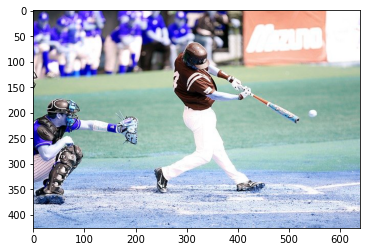

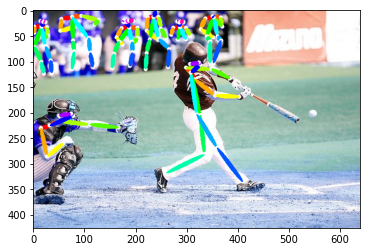

In [26]:
from utils.decode_pose import decode_pose
_,result_img,_,_=decode_pose(oriImg,heatmaps,pafs)

#結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()